# Validating evaluation methods

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import os
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import torch
import torch.nn as nn
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from hydra.utils import instantiate
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import CSVLogger, WandbLogger
from omegaconf import DictConfig, OmegaConf, open_dict
from torchmetrics import MetricCollection
from torchmetrics.functional import pairwise_cosine_similarity, retrieval_hit_rate
from torchmetrics.retrieval import (
    RetrievalFallOut,
    RetrievalHitRate,
    RetrievalMAP,
    RetrievalMRR,
    RetrievalNormalizedDCG,
    RetrievalPrecision,
    RetrievalRPrecision,
)
from umap import UMAP

from src import utils
from src.eval.retrieval import IDRRetrievalDataModule, IDRRetrievalEvaluator, IDRRetrievalModule
from src.eval.simple_retrieval.evaluator import concat_from_list_of_dict_to_list, concat_from_list_of_dict_to_tensor
from src.modules.compound_transforms import DGLPretrainedFromSmiles
from src.modules.images import CNNEncoder
from src.modules.molecules import GINPretrainedWithLinearHead

In [4]:
for i in range(1, 4):
    if not Path(f"../cpjump{i}/jump/").exists():
        print(f"Mounting cpjump{i}...")
        os.system(f"sshfs bioclust:/projects/cpjump{i}/ ../cpjump{i}")
    else:
        print(f"cpjump{i} already mounted.")

Mounting cpjump1...
Mounting cpjump2...
Mounting cpjump3...


## Loading config

In [4]:
GlobalHydra.instance().clear()

In [5]:
initialize(version_base=None, config_path="../configs")

hydra.initialize()

In [6]:
cfg = compose(
    config_name="train.yaml",
    overrides=[
        "evaluate=true",
        "eval=evaluators",
        "paths.projects_dir=..",
        "paths.output_dir=./tmp/21312FS12A",
        "experiment=final/dataset_experiments/small.yaml",
        "data.batch_size=4",
        "trainer.devices=1",
    ],
)
print(OmegaConf.to_yaml(cfg))

task_name: train
tags:
- final_experiments
- pretrained
- ntxent
- single_view
- resnet34
- pna
train: true
load_first_bacth: true
test: true
evaluate: true
compile: false
ckpt_path: null
seed: 12345
data:
  compound_transform:
    _target_: src.modules.compound_transforms.pna.PNATransform
    compound_str_type: inchi
  transform:
    _target_: src.modules.transforms.ComplexTransform
    _convert_: object
    size: 512
    flip_p: 0.5
    resize_p: 0.3
    color_p: 0.2
    resize_min_ratio: 0.9
    intensity: 0.2
    brightness: 0.1
    fill_nan: true
    use_flip: true
    use_blur: false
    use_color_jitter: true
    use_drop: false
    use_resized_crop: true
  _target_: src.models.jump_cl.datamodule.BasicJUMPDataModule
  batch_size: 4
  num_workers: 16
  pin_memory: null
  prefetch_factor: 2
  drop_last: true
  force_split: false
  splitter:
    _target_: src.splitters.RandomSplitter
    train: 4096
    test: 8192
    val: 4096
    retrieval: 4096
  use_compond_cache: false
  data_

In [7]:
cfg.eval.keys()

dict_keys(['simple_retrieval', 'lipo', 'esol', 'bbbp', 'hiv', 'phaseI', 'phaseII', 'phaseIII', 'idr_graph_retrieval', 'batch_effect', 'plate_normalized'])

## Batch effect

In [11]:
print(OmegaConf.to_yaml(cfg.eval.batch_effect))

trainer:
  _target_: lightning.pytorch.trainer.Trainer
  default_root_dir: ${paths.output_dir}/eval/batch_effect/new
  min_epochs: 5
  max_epochs: 20
  accelerator: gpu
  detect_anomaly: true
  devices: 1
  check_val_every_n_epoch: 1
  deterministic: false
  limit_predict_batches: 3
evaluator:
  _target_: src.eval.batch_effect.evaluator.BatchEffectEvaluator
  dmso_normalize: false
  normalize_cls: null
  embedding_col: projection
  test_size: 0.2
  nruns: 5
  plot: true
  logistic: true
  knn: true
  batch_split: true
  plate_split: true
  source_split: true
  well_split: true
  fully_random_split: true
  out_dir: ${paths.output_dir}/eval/batch_effect/new/
  name: null
  visualize_kwargs: null
model:
  _target_: src.eval.batch_effect.module.TotalBatchEffectModule
datamodule:
  _target_: src.eval.batch_effect.datamodule.TotalBatchEffectDataModule
  target_load_df_path: ${paths.data_root_dir}/jump/models/eval/batch_effect/splits/target_load_df.csv
  dmso_load_df_path: ${paths.data_root_d

In [15]:
cfg.eval.batch_effect.trainer.devices = 1
cfg.eval.batch_effect.datamodule.batch_size = 4

with open_dict(cfg.eval.batch_effect.trainer):
    cfg.eval.batch_effect.trainer.limit_predict_batches = 3

In [12]:
batch_effect = utils.instantiate_evaluator(cfg.eval.batch_effect, cfg.model)

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Plea

Creating output directory ./tmp/21312FS12A/eval/batch_effect/new/...


In [21]:
self = batch_effect.datamodule
for channel in ["DNA", "AGP", "ER", "Mito", "RNA"]:
    self.target_load_df.loc[:, f"FileName_Orig{channel}"] = self.target_load_df[f"FileName_Orig{channel}"].str.replace(
        "/projects/", "../"
    )

In [27]:
self = batch_effect

In [25]:
batch_effect.get_embeddings()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Fitting t-SNE...


/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

Saved batch_effect/regular/Embeddings/t-SNE colored by labels to ./tmp/21312FS12A/eval/batch_effect/new/batch_effect/regular/Embeddings/t-SNE_colored_by_labels.png


/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

Saved batch_effect/regular/Embeddings/t-SNE colored by batch to ./tmp/21312FS12A/eval/batch_effect/new/batch_effect/regular/Embeddings/t-SNE_colored_by_batch.png
Saved batch_effect/regular/Embeddings/t-SNE colored by plate to ./tmp/21312FS12A/eval/batch_effect/new/batch_effect/regular/Embeddings/t-SNE_colored_by_plate.png


/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

Saved batch_effect/regular/Embeddings/t-SNE colored by well to ./tmp/21312FS12A/eval/batch_effect/new/batch_effect/regular/Embeddings/t-SNE_colored_by_well.png


/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

Saved batch_effect/regular/Embeddings/t-SNE colored by source to ./tmp/21312FS12A/eval/batch_effect/new/batch_effect/regular/Embeddings/t-SNE_colored_by_source.png


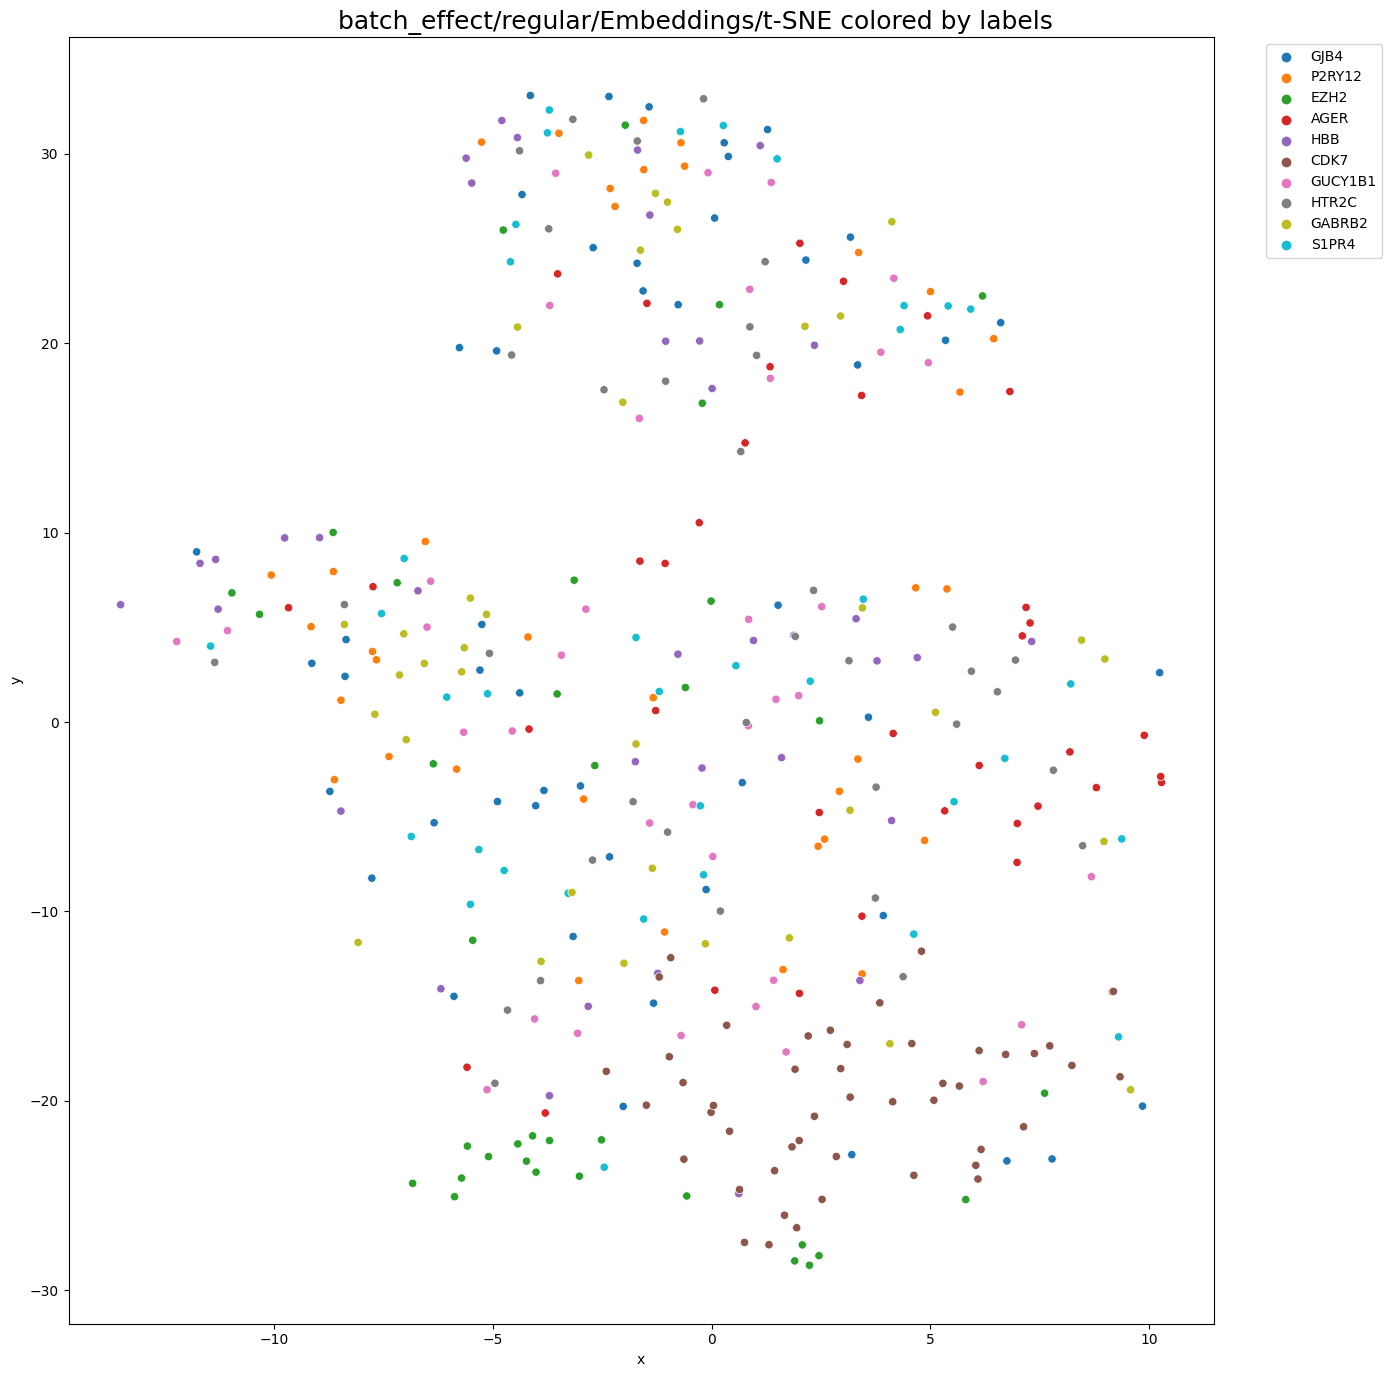

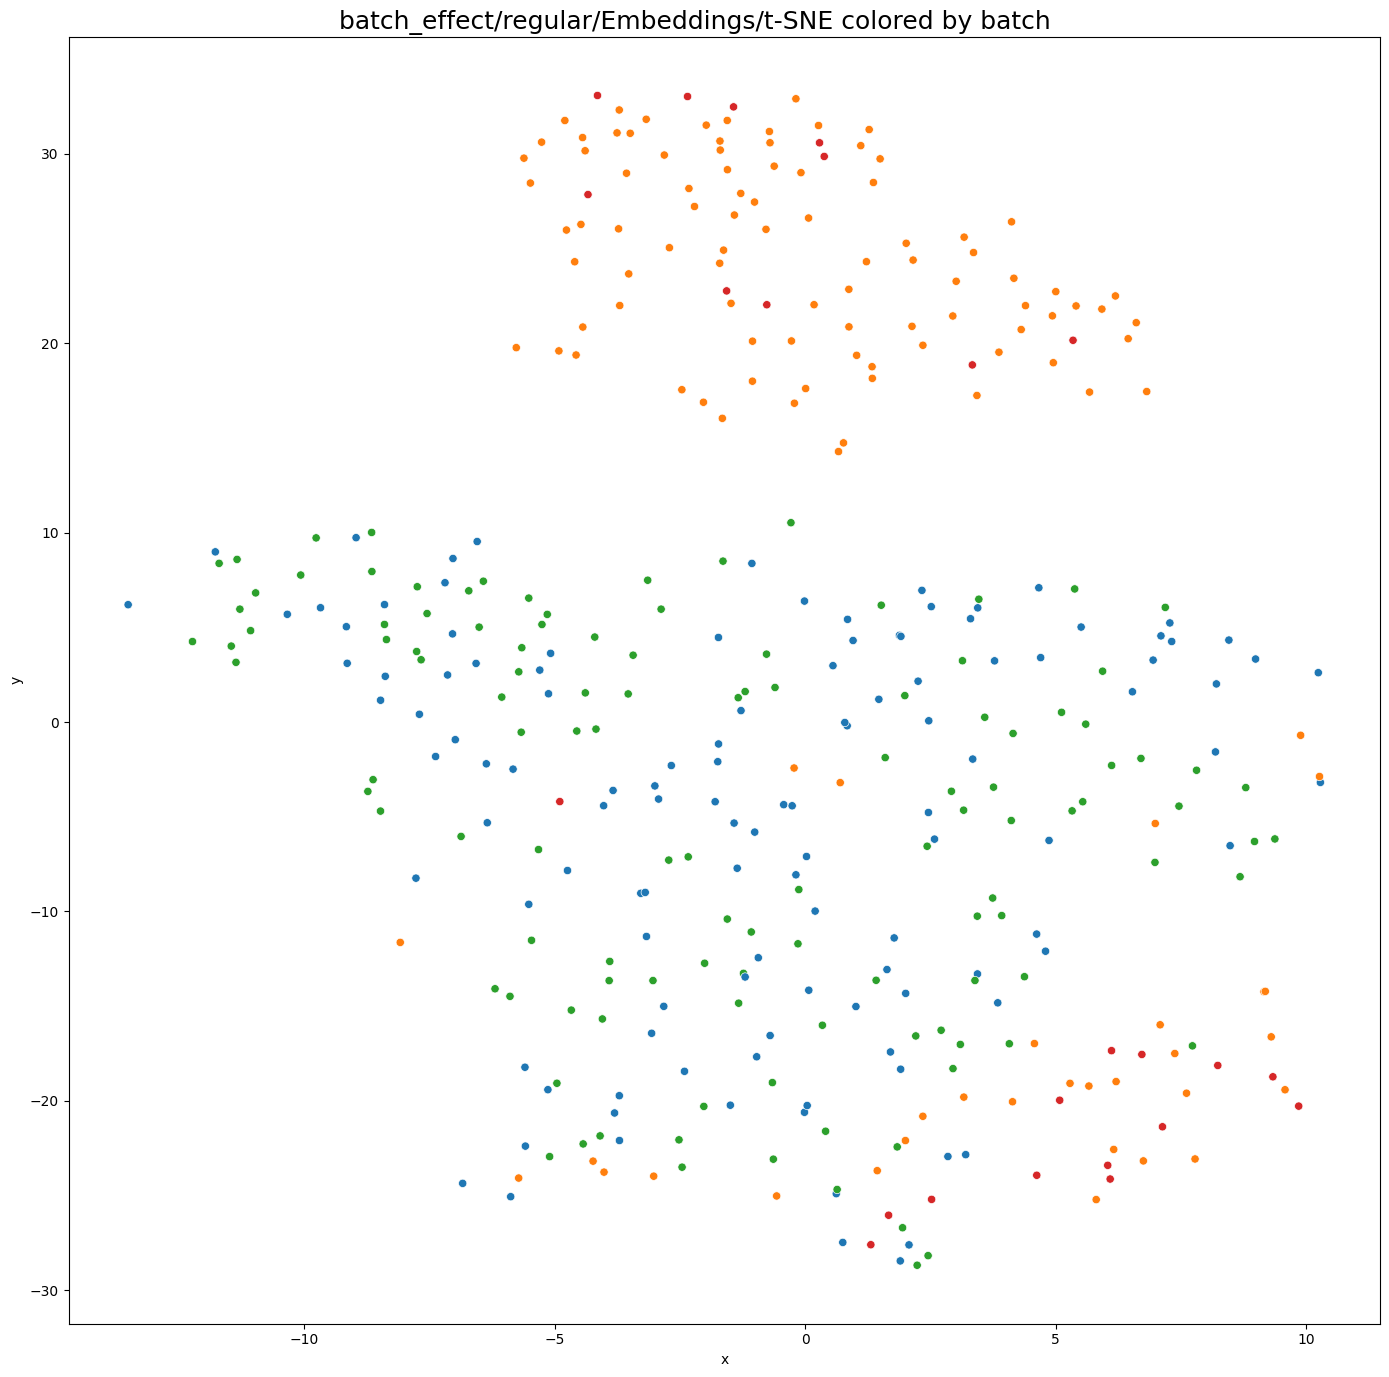

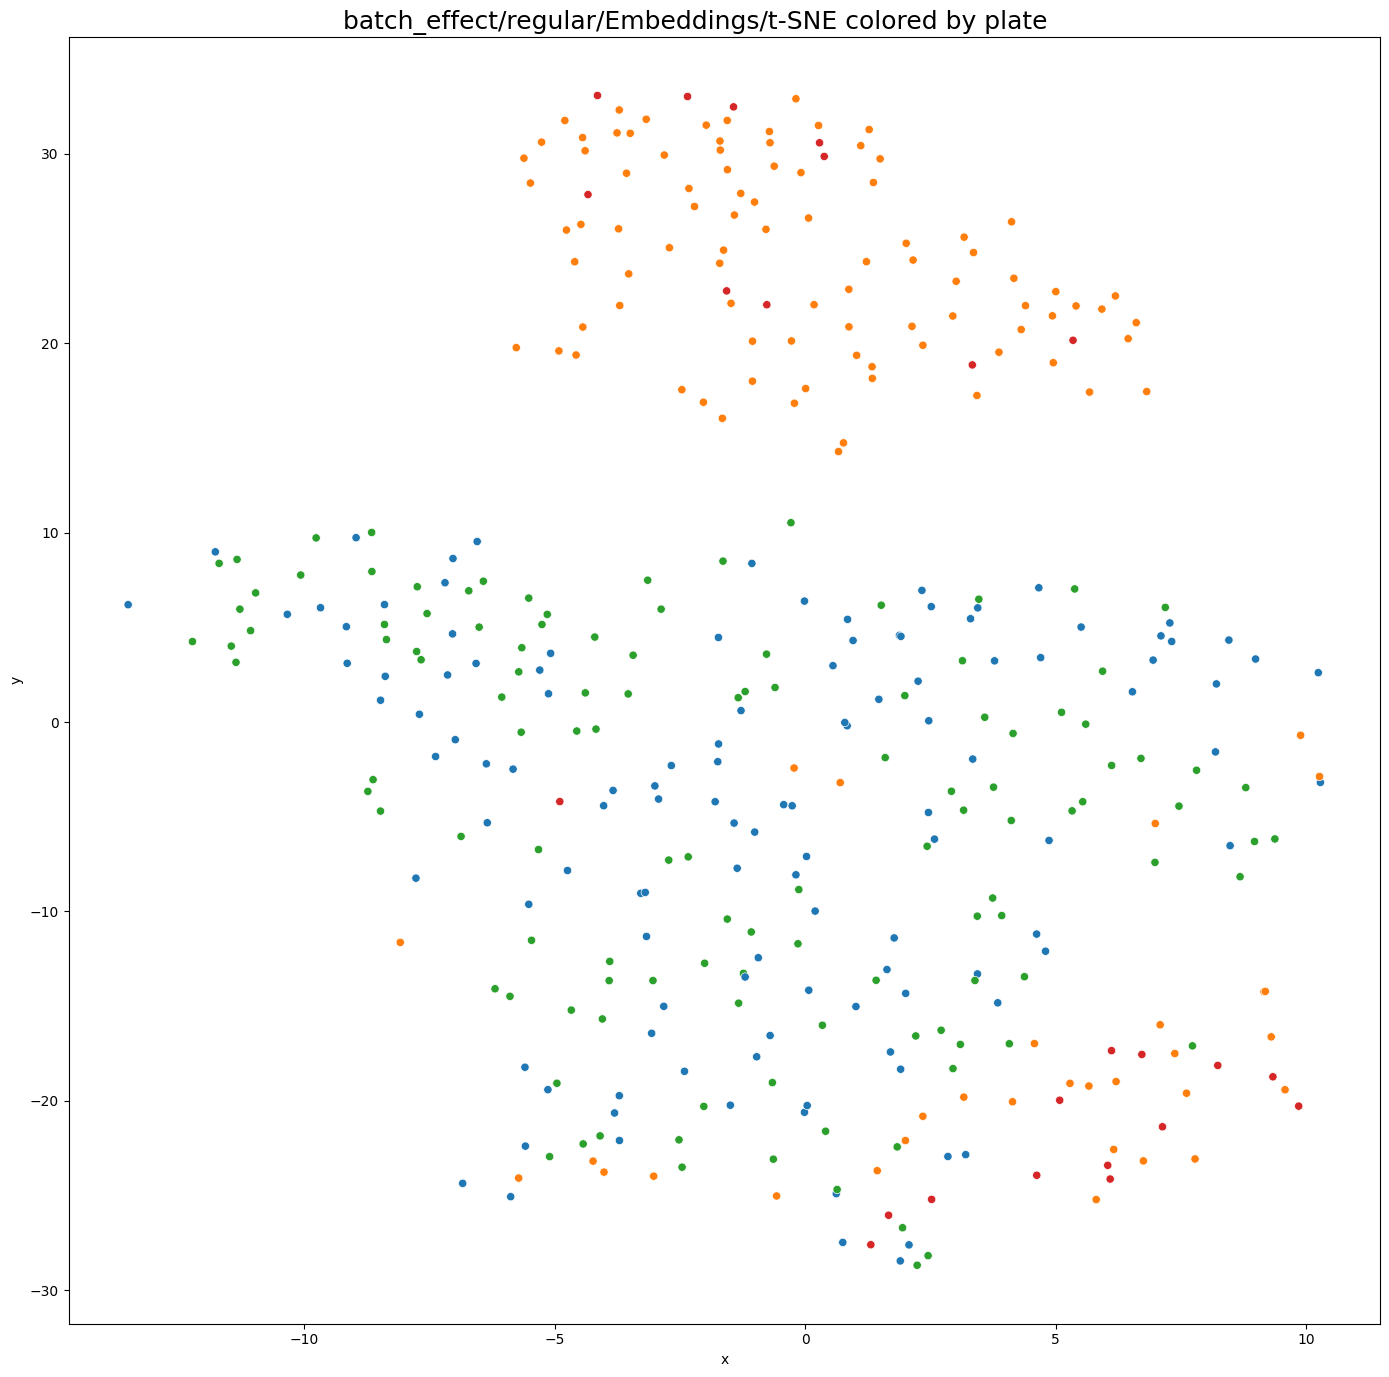

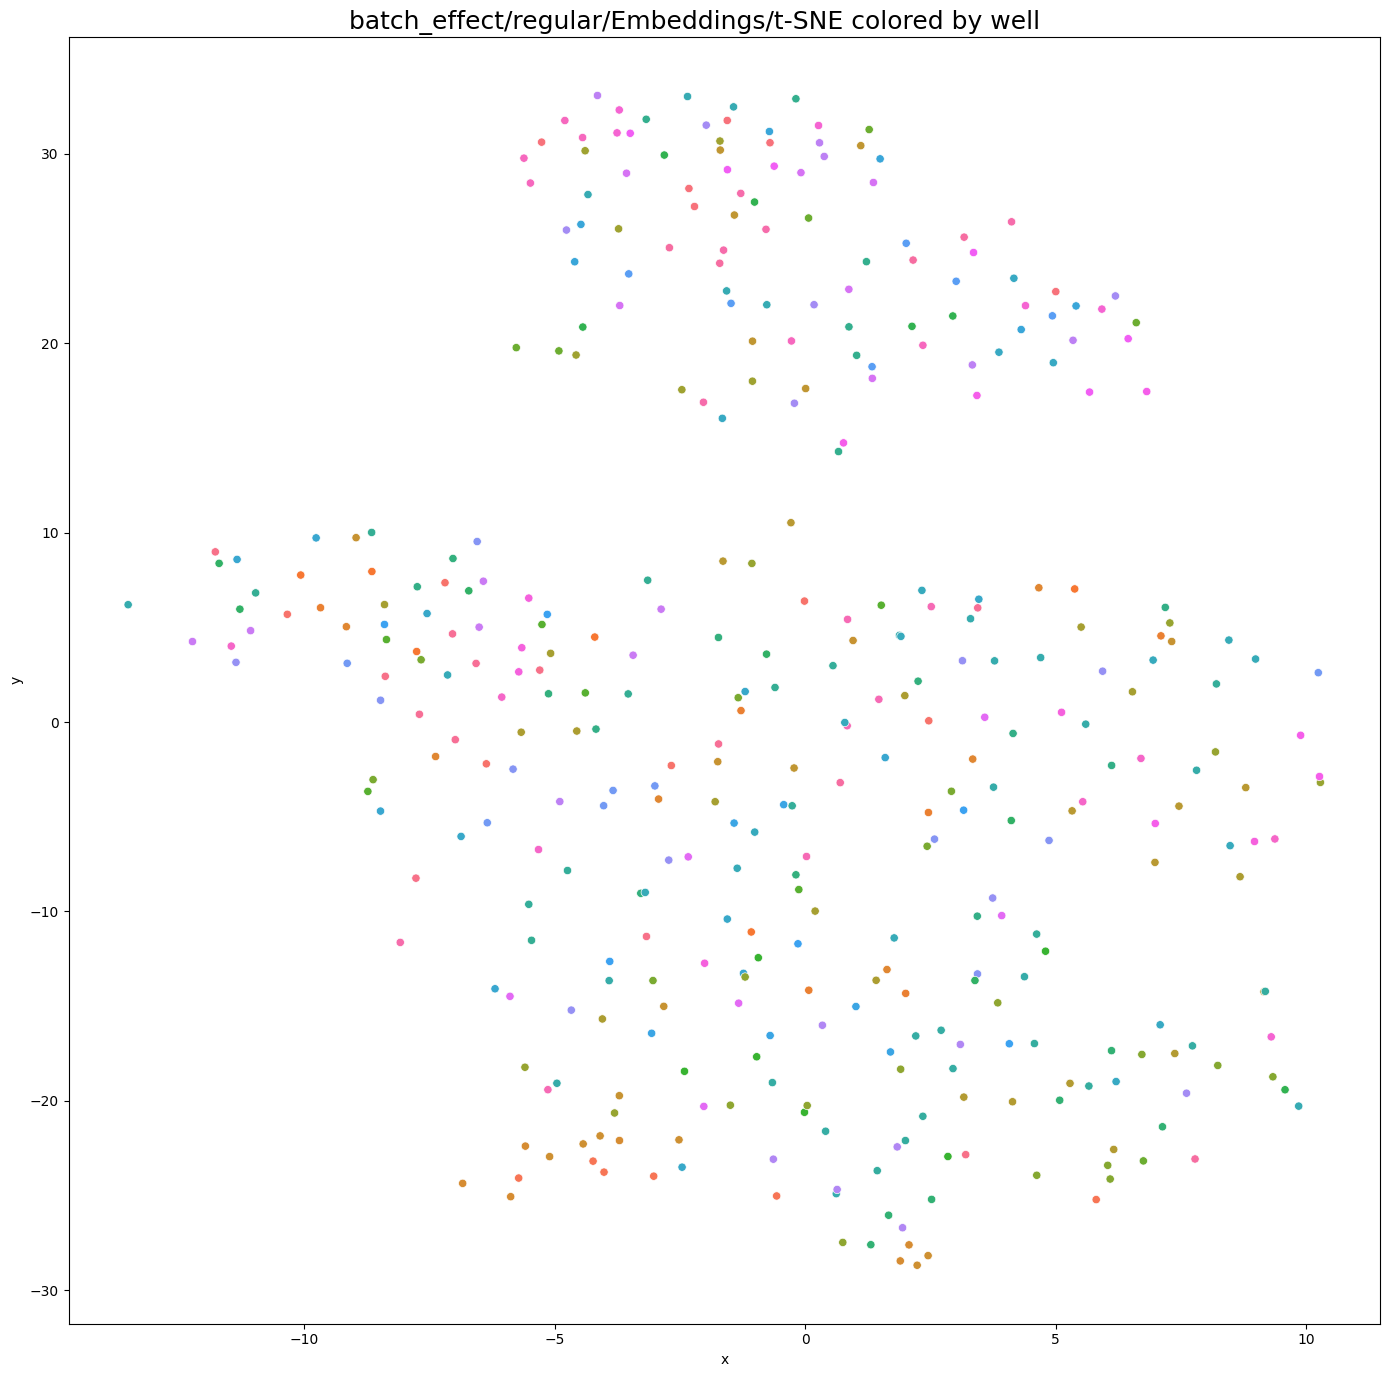

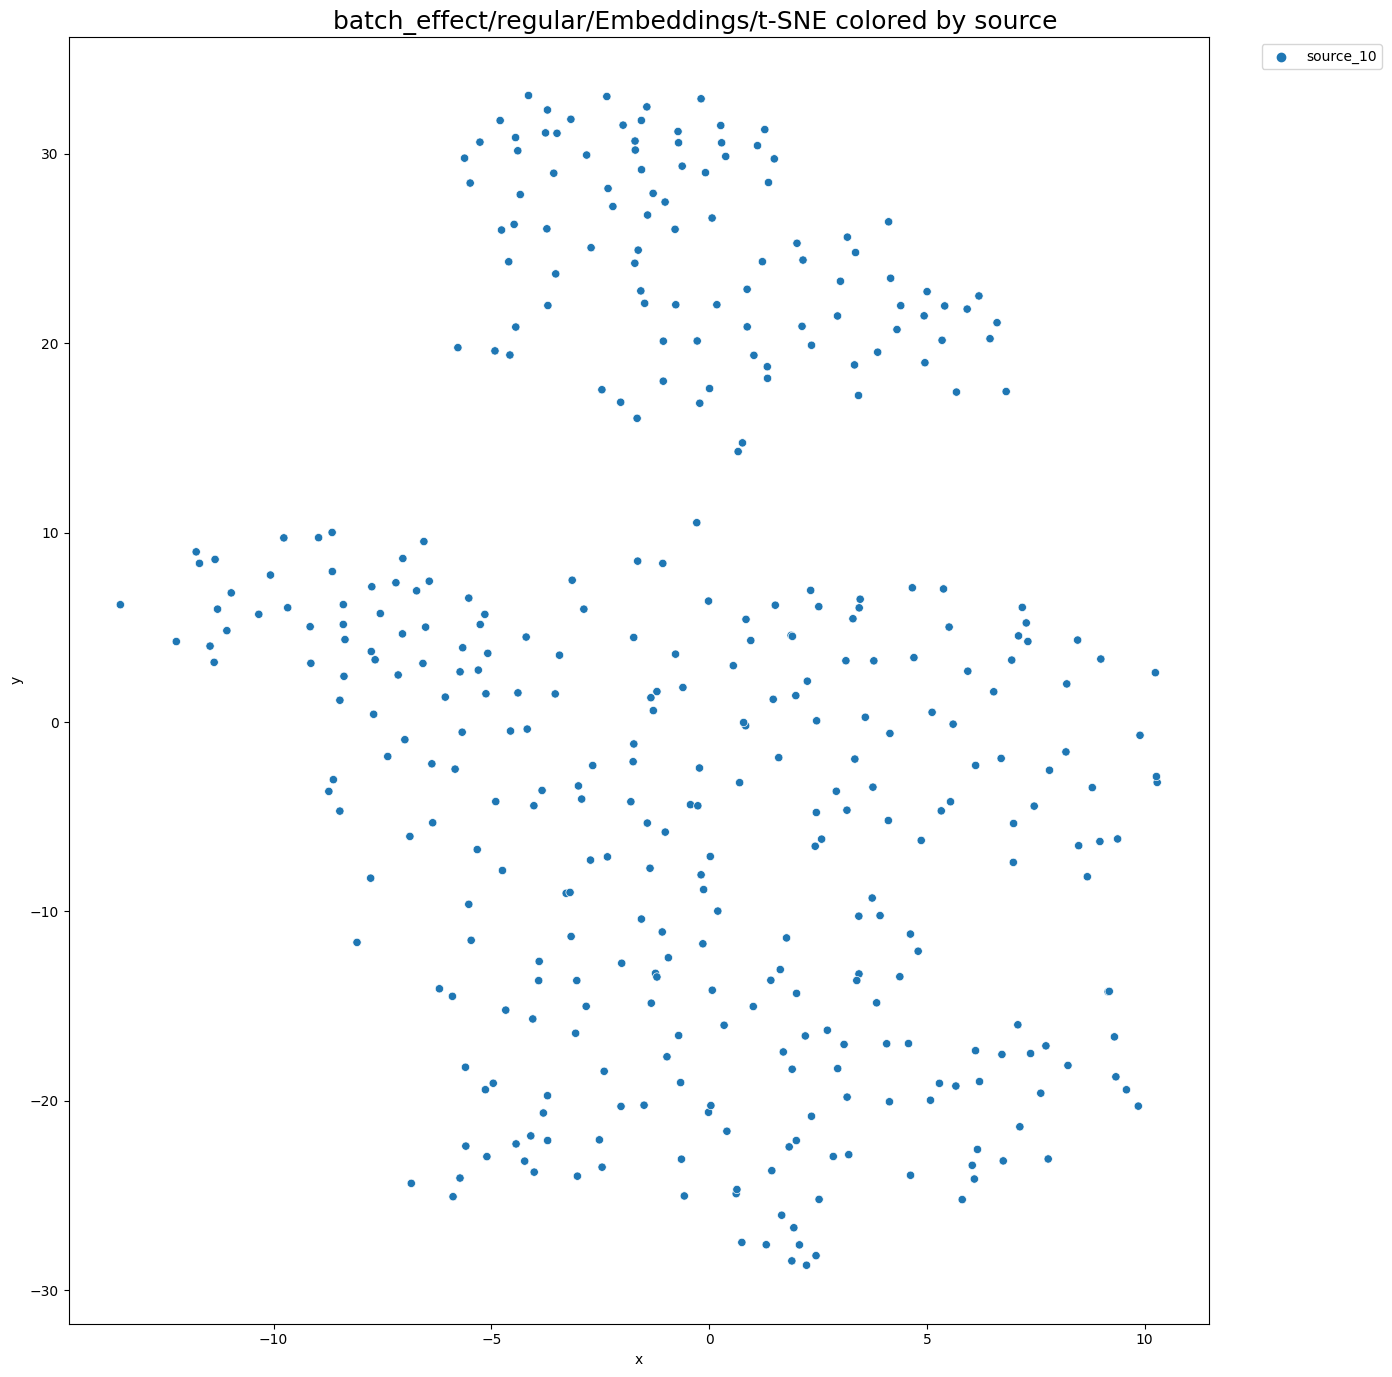

In [28]:
images = self.plot_embeddings(key="batch_effect/regular/Embeddings")

In [29]:
images

[<Figure size 1400x1400 with 1 Axes>,
 <Figure size 1400x1400 with 1 Axes>,
 <Figure size 1400x1400 with 1 Axes>,
 <Figure size 1400x1400 with 1 Axes>,
 <Figure size 1400x1400 with 1 Axes>]

## IDR retrieval

In [110]:
cfg.eval.idr_graph_retrieval

{'trainer': {'_target_': 'lightning.pytorch.trainer.Trainer', 'default_root_dir': '${paths.output_dir}/eval/retrieval/idr/', 'min_epochs': 5, 'max_epochs': 20, 'accelerator': 'gpu', 'detect_anomaly': True, 'devices': '${trainer.devices}', 'check_val_every_n_epoch': 1, 'deterministic': False}, 'model': {'_target_': 'src.eval.retrieval.module.IDRRetrievalModule', 'example_input_path': None}, 'datamodule': {'_target_': 'src.eval.retrieval.datamodule.IDRRetrievalDataModule', 'image_metadata_path': '${paths.data_root_dir}/idr0033-rohban-pathways/processed_metadata.csv', 'excape_db_path': '${paths.data_root_dir}/excape-db/excape_db_df.csv', 'selected_group_path': '${paths.data_root_dir}/excape-db/processed_groups.json', 'data_root_dir': '${paths.data_root_dir}/screen_1751', 'image_batch_size': 128, 'compound_batch_size': 1, 'num_workers': 16, 'pin_memory': False, 'prefetch_factor': 2, 'compound_transform': '${data.compound_transform}', 'transform': '${data.transform}', 'image_gene_col': 'Gen

In [112]:
cfg.eval.idr_graph_retrieval.trainer.devices = 1

with open_dict(cfg.eval.idr_graph_retrieval.trainer):
    cfg.eval.idr_graph_retrieval.trainer.limit_predict_batches = 3

In [113]:
idr = utils.instantiate_evaluator(cfg.eval.idr_graph_retrieval, cfg.model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [114]:
self = idr

In [115]:
self.datamodule.prepare_data()
self.datamodule.setup(stage="predict")
self.model.eval()

IDRRetrievalModule(
  (image_encoder): CNNEncoder(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act1): ReLU(inplace=True)
          (aa): Identity()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): ReLU(inplace=True)
        )
        (1): BasicBlock(
   

In [116]:
predict_loaders = self.datamodule.predict_dataloader()

In [117]:
predict_loaders

{'BRCA1': {'molecule': <torch.utils.data.dataloader.DataLoader at 0x7f76843a60b0>,
  'image': <torch.utils.data.dataloader.DataLoader at 0x7f768455d2d0>},
 'HIF1A': {'molecule': <torch.utils.data.dataloader.DataLoader at 0x7f768455e5c0>,
  'image': <torch.utils.data.dataloader.DataLoader at 0x7f768455d840>},
 'HSPA5': {'molecule': <torch.utils.data.dataloader.DataLoader at 0x7f768455e560>,
  'image': <torch.utils.data.dataloader.DataLoader at 0x7f7684a83640>},
 'JUN': {'molecule': <torch.utils.data.dataloader.DataLoader at 0x7f7684a83ca0>,
  'image': <torch.utils.data.dataloader.DataLoader at 0x7f7684a82e30>},
 'STAT3': {'molecule': <torch.utils.data.dataloader.DataLoader at 0x7f7684a805e0>,
  'image': <torch.utils.data.dataloader.DataLoader at 0x7f7684a83850>},
 'TP53': {'molecule': <torch.utils.data.dataloader.DataLoader at 0x7f7684a82500>,
  'image': <torch.utils.data.dataloader.DataLoader at 0x7f7684a82ec0>}}

In [120]:
def concat_from_list_of_dict(res, key):
    return torch.cat([r[key] for r in res], dim=0)

In [136]:
predict_loaders[gene]["molecule"].dataset[0]

{'activity_flag': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0],
 'compound': Graph(num_nodes=2756, num_edges=5982,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)})}

In [140]:
b = next(iter(predict_loaders[gene]["molecule"]))

In [141]:
b

{'activity_flag': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
          0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]),
 'compound': Graph(num_nodes=2756, num_edges=5982,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)})}

In [153]:
gene = "BRCA1"
out_metrics = defaultdict(lambda: 0)

compound_embs = self.trainer.predict(self.model, predict_loaders[gene]["molecule"])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

In [167]:
image_emb = self.trainer.predict(self.model, predict_loaders[gene]["image"])
# Only needed if more images than batch size (rare) -> Ni x E
image_emb = concat_from_list_of_dict(image_emb, "image")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [178]:
out_metrics = defaultdict(lambda: defaultdict(list))
for gene in predict_loaders:
    # List of the embeddings of each group -> Ng x 120 x E
    compound_embs = self.trainer.predict(self.model, predict_loaders[gene]["molecule"])

    image_emb = self.trainer.predict(self.model, predict_loaders[gene]["image"])
    # Only needed if more images than batch size (rare) -> Ni x E
    image_emb = concat_from_list_of_dict(image_emb, "image")

    for group in compound_embs:
        activities = group["activity_flag"]
        compound_emb = group["compound"]

        gene_group_metrics = self.model.retrieval(
            image_embeddings=image_emb, compound_embeddings=compound_emb, activities=activities
        )

        for metric in gene_group_metrics:
            out_metrics[gene][metric].append(gene_group_metrics[metric])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [181]:
aggregate_metrics = defaultdict(lambda: 0)
for gene in out_metrics:
    for metric in out_metrics[gene]:
        aggregate_metrics[f"{gene}/{metric}_mean"] = np.mean(out_metrics[gene][metric])
        aggregate_metrics[f"{gene}/{metric}_std"] = np.std(out_metrics[gene][metric])

num_genes = len(out_metrics)
for gene in out_metrics:
    for metric in out_metrics[gene]:
        aggregate_metrics[f"Average/{metric}"] += aggregate_metrics[f"{gene}/{metric}_mean"] / num_genes

aggregate_metrics = dict(aggregate_metrics)

In [186]:
out_metrics["HIF1A"]["RetrievalHitRate_top_1"]

[tensor(1.), tensor(0.), tensor(0.0361)]

In [184]:
aggregate_metrics

{'BRCA1/RetrievalFallOut_top_1_mean': 0.007837837,
 'BRCA1/RetrievalFallOut_top_1_std': 0.0017653977,
 'BRCA1/RetrievalFallOut_top_5_mean': 0.02936937,
 'BRCA1/RetrievalFallOut_top_5_std': 0.012875639,
 'BRCA1/RetrievalHitRate_top_1_mean': 0.21621622,
 'BRCA1/RetrievalHitRate_top_1_std': 0.17653981,
 'BRCA1/RetrievalHitRate_top_10_mean': 0.981982,
 'BRCA1/RetrievalHitRate_top_10_std': 0.025481338,
 'BRCA1/RetrievalHitRate_top_3_mean': 0.6666667,
 'BRCA1/RetrievalHitRate_top_3_std': 0.47140452,
 'BRCA1/RetrievalHitRate_top_5_mean': 0.7477477,
 'BRCA1/RetrievalHitRate_top_5_std': 0.35673857,
 'BRCA1/RetrievalMAP_top_1_mean': 0.21621622,
 'BRCA1/RetrievalMAP_top_1_std': 0.17653981,
 'BRCA1/RetrievalMAP_top_5_mean': 0.46755505,
 'BRCA1/RetrievalMAP_top_5_std': 0.29398072,
 'BRCA1/RetrievalMRR_mean': 0.49007556,
 'BRCA1/RetrievalMRR_std': 0.24107137,
 'BRCA1/RetrievalNormalizedDCG_mean': 0.6531406,
 'BRCA1/RetrievalNormalizedDCG_std': 0.06759104,
 'BRCA1/RetrievalPrecision_top_1_mean': 0.21

In [169]:
gene_metrics

{'RetrievalFallOut_top_1': tensor(0.0076),
 'RetrievalFallOut_top_5': tensor(0.0205),
 'RetrievalHitRate_top_1': tensor(0.2432),
 'RetrievalHitRate_top_10': tensor(1.),
 'RetrievalHitRate_top_3': tensor(1.),
 'RetrievalHitRate_top_5': tensor(1.),
 'RetrievalMAP_top_1': tensor(0.2432),
 'RetrievalMAP_top_5': tensor(0.6466),
 'RetrievalMRR': tensor(0.6216),
 'RetrievalNormalizedDCG': tensor(0.6980),
 'RetrievalPrecision_top_1': tensor(0.2432),
 'RetrievalPrecision_top_10': tensor(0.4135),
 'RetrievalPrecision_top_3': tensor(0.5946),
 'RetrievalPrecision_top_5': tensor(0.5892),
 'RetrievalRecall_top_1': tensor(0.0122),
 'RetrievalRecall_top_10': tensor(0.2068),
 'RetrievalRecall_top_3': tensor(0.0892),
 'RetrievalRecall_top_5': tensor(0.1473)}

In [157]:
activities.shape, compound_emb.shape, image_emb.shape

(torch.Size([120]), torch.Size([120, 512]), torch.Size([37, 512]))

In [119]:
out_metrics = defaultdict(lambda: defaultdict(lambda: 0))
for gene in predict_loaders:
    # List of the embeddings of each group -> Ng x 120 x E
    compound_embs = self.trainer.predict(self.model, predict_loaders[gene]["molecule"])

    # activities = concat_from_list_of_dict(compound_emb, "activity_flag")
    # compound_emb = concat_from_list_of_dict(compound_emb, "compound")

    image_emb = self.trainer.predict(self.model, predict_loaders[gene]["image"])
    # Only needed if more images than batch size (rare) -> Ni x E
    image_emb = concat_from_list_of_dict(image_emb, "image")

    num_groups = len(compound_embs)
    for group in compound_embs:
        activities = group["activity_flag"]
        compound_emb = group["compound"]

        gene_group_metrics = self.model.retrieval(
            image_embeddings=image_emb, compound_embeddings=compound_emb, activities=activities
        )

        for metric in gene_group_metrics:
            out_metrics[gene][metric] += gene_group_metrics[metric] / num_groups

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found object

In [ ]:
def evaluate(self):
    self.datamodule.prepare_data()
    self.datamodule.setup(stage="predict")
    self.model.eval()

    predict_loaders = self.datamodule.predict_dataloader()

    out_metrics = defaultdict(lambda: defaultdict(lambda: 0))
    for gene in predict_loaders:
        # List of the embeddings of each group -> Ng x 120 x E
        compound_embs = self.trainer.predict(self.model, predict_loaders[gene]["molecule"])

        # activities = concat_from_list_of_dict(compound_emb, "activity_flag")
        # compound_emb = concat_from_list_of_dict(compound_emb, "compound")

        image_emb = self.trainer.predict(self.model, predict_loaders[gene]["image"])
        # Only needed if more images than batch size (rare) -> Ni x E
        image_emb = concat_from_list_of_dict(image_emb, "image")

        num_groups = len(compound_embs)
        for group in compound_embs:
            activities = group["activity_flag"]
            compound_emb = group["compound"]

            gene_group_metrics = self.model.retrieval(
                image_embeddings=image_emb, compound_embeddings=compound_emb, activities=activities
            )

            for metric in gene_group_metrics:
                out_metrics[gene][metric] += gene_group_metrics[metric] / num_groups

    out_metrics = dict(out_metrics)

    mean_metrics = defaultdict(lambda: 0)
    num_genes = len(out_metrics)
    for gene in out_metrics:
        for metric in out_metrics[gene]:
            mean_metrics[metric] += out_metrics[gene][metric] / num_genes
    mean_metrics = dict(mean_metrics)

    out_metrics["Average"] = mean_metrics

    unfold_metrics = {}
    for gene in out_metrics:
        for metric in out_metrics[gene]:
            unfold_metrics[f"{gene}/{metric}"] = out_metrics[gene][metric]

    for logger in self.trainer.loggers:
        logger.log_metrics(unfold_metrics)
        logger.save()

    return unfold_metrics

## Simple retrieval

In [7]:
cfg.eval.simple_retrieval.datamodule.batch_size = 4
cfg.eval.simple_retrieval.trainer.devices = 1

with open_dict(cfg.eval.simple_retrieval.trainer):
    cfg.eval.simple_retrieval.trainer.limit_predict_batches = 3

In [8]:
simple = utils.instantiate_evaluator(cfg.eval.simple_retrieval, cfg.model)

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Plea

In [9]:
simple.datamodule.setup()

[2023-09-29 10:05:35,761][src.eval.simple_retrieval.datamodule][INFO] - Preparing retrieval dataset


Preparing retrieval dataset


In [10]:
dl = simple.datamodule.predict_dataloader()

In [12]:
b = next(iter(dl))

In [13]:
simple.model.predict_step(b, 0)

{'dataloader_idx': 0,
 'batch_idx': 0,
 'compound_str': ['InChI=1S/C10H10ClN3O2/c11-7-2-1-3-8(4-7)14-10(6-16)9(5-15)12-13-14/h1-4,15-16H,5-6H2',
  'InChI=1S/C10H10ClN3O2S2/c11-9-1-2-10(17-9)18(15,16)14-4-3-7-8(5-14)13-6-12-7/h1-2,6H,3-5H2,(H,12,13)',
  'InChI=1S/C10H10N2O3S2/c1-2-5-3-6-8(15)11-10(12-9(6)17-5)16-4-7(13)14/h3H,2,4H2,1H3,(H,13,14)(H,11,12,15)',
  'InChI=1S/C10H10N4O2/c1-16-10(15)8-9(11)13-14(12-8)7-5-3-2-4-6-7/h2-6H,1H3,(H2,11,13)'],
 'image_id': ['source_3__CP_32_all_Phenix1__B40803aW__M17__5',
  'source_5__JUMPCPE-20211001-Run34_20211003_121618__AEOJUM706__I07__5',
  'source_3__CP_25_all_Phenix1__C13443cW__M09__8',
  'source_11__Batch5__EC000080__N08__7'],
 'compound_emb': tensor([[ 0.0327,  0.0120,  0.0249,  ...,  0.0612, -0.0171,  0.0168],
         [ 0.0138,  0.0257,  0.0455,  ...,  0.0423, -0.0302, -0.0043],
         [-0.0339,  0.0250,  0.0533,  ...,  0.0405, -0.0005,  0.0017],
         [ 0.0103,  0.0324,  0.0354,  ...,  0.0830,  0.0246, -0.0099]],
        grad_fn=<A

In [14]:
predictions = simple.trainer.predict(simple.model, simple.datamodule)

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [15]:
predictions

[{'dataloader_idx': 0,
  'batch_idx': 0,
  'compound_str': ['InChI=1S/C10H10ClN3O2/c11-7-2-1-3-8(4-7)14-10(6-16)9(5-15)12-13-14/h1-4,15-16H,5-6H2',
   'InChI=1S/C10H10ClN3O2S2/c11-9-1-2-10(17-9)18(15,16)14-4-3-7-8(5-14)13-6-12-7/h1-2,6H,3-5H2,(H,12,13)',
   'InChI=1S/C10H10N2O3S2/c1-2-5-3-6-8(15)11-10(12-9(6)17-5)16-4-7(13)14/h3H,2,4H2,1H3,(H,13,14)(H,11,12,15)',
   'InChI=1S/C10H10N4O2/c1-16-10(15)8-9(11)13-14(12-8)7-5-3-2-4-6-7/h2-6H,1H3,(H2,11,13)'],
  'image_id': ['source_1__Batch5_20221030__UL001783__Y33__4',
   'source_5__JUMPCPE-20210813-Run21_20210817_031500__AEOJUM306__I07__6',
   'source_2__20211003_Batch_13__1086289679__J15__6',
   'source_11__Batch5__EC000080__N08__3'],
  'compound_emb': tensor([[ 0.0664,  0.0206,  0.0666,  ...,  0.0872,  0.0205,  0.0165],
          [ 0.0403,  0.0211,  0.0683,  ...,  0.0720,  0.0300,  0.0240],
          [-0.0064,  0.0153,  0.1039,  ...,  0.1087, -0.0030,  0.0428],
          [ 0.0275,  0.0038,  0.1197,  ...,  0.0570, -0.0118,  0.0282]]),
  '

In [ ]:
predictions2 = copy.deepcopy(predictions)

In [76]:
keys = predictions2[0].keys()
print("Aggregating predictions2 for plot...")
res = {}
for k in keys:
    try:
        res[k] = np.array(concat_from_list_of_dict_to_tensor(predictions2, k))
    except Exception as e:
        print(e)

print("Computing similarity...")
sim = simple.one_to_one(torch.Tensor(res["image_emb"]), torch.Tensor(res["compound_emb"])).numpy()  # 4k x 2
total_sim = np.concatenate([sim, sim])
total_emb = np.vstack([res["image_emb"], res["compound_emb"]])
labels = list(res["image_id"]) + list(res["compound_str"])
sources = [x.split("__")[0] for x in res["image_id"]] + ["compound"] * len(res["compound_emb"])
type_label = ["image"] * len(res["image_emb"]) + ["compound"] * len(res["compound_emb"])

print(f"{len(total_emb)} items to plot")

print("Computing UMAP...")
pca = UMAP(n_components=2)
proj = pca.fit_transform(total_emb)

Aggregating predictions2 for plot...
Computing similarity...
24 items to plot
Computing UMAP...


In [92]:
proj_dict = {
    "x": proj[:, 0],
    "y": proj[:, 1],
    "type": type_label,
    "source": sources,
    "labels": labels,
    "pair_id": list(range(len(res["image_emb"]))) + list(range(len(res["compound_emb"]))),
    "sim": total_sim,
}
proj_df = pd.DataFrame(proj_dict)
proj_df["pos_sim"] = 1 + proj_df["sim"]

In [93]:
proj_df

,x,y,type,source,labels,pair_id,sim,pos_sim
0,-8.214688,6.548483,image,source_1,source_1__Batch5_20221030__UL001783__Y33__4,0,-0.050959,0.949041
1,-9.038458,7.369855,image,source_5,source_5__JUMPCPE-20210813-Run21_20210817_0315...,1,-0.037649,0.962351
2,-8.718319,5.707255,image,source_2,source_2__20211003_Batch_13__1086289679__J15__6,2,-0.027482,0.972518
3,-8.396246,5.707200,image,source_11,source_11__Batch5__EC000080__N08__3,3,-0.040448,0.959552
4,-9.317872,6.763498,image,source_2,source_2__20210808_Batch_4__1086292747__O15__3,4,-0.009715,0.990285
5,-9.586867,6.429927,image,source_2,source_2__20211003_Batch_13__1086289716__I10__2,5,-0.048885,0.951115
6,-9.184655,5.464608,image,source_2,source_2__20210808_Batch_4__1086292853__A12__3,6,-0.001127,0.998873
7,-8.293722,7.318344,image,source_9,source_9__20210825_Run6__GR00003391__W42__2,7,-0.049404,0.950596
8,-9.017653,6.273812,image,source_8,source_8__J2__A1170478__D15__4,8,-0.046670,0.953330
9,-8.812129,6.823203,image,source_6,source_6__p210920CPU2OS48hw384exp028JUMP__1100...,9,-0.003238,0.996762


In [95]:
fig = px.scatter(
    proj_df,
    x="x",
    y="y",
    color="source",
    size="pos_sim",
    symbol="type",
    hover_data=["labels", "pair_id", "sim"],
)

In [96]:
fig

In [100]:
simple.visualize_embeddings(predictions, False, False)

Aggregating predictions for plot...
Computing similarity...
24 items to plot
Computing UMAP...


In [20]:
keys = predictions2[0].keys()
print("Aggregating predictions for plot...")
res = {}
for k in keys:
    try:
        res[k] = np.array(concat_from_list_of_dict_to_tensor(predictions2, k))
    except Exception as e:
        print(e)

Aggregating predictions for plot...


In [27]:
simple.distance_metric

<function torchmetrics.functional.pairwise.cosine.pairwise_cosine_similarity(x: torch.Tensor, y: Optional[torch.Tensor] = None, reduction: Literal['mean', 'sum', 'none', None] = None, zero_diagonal: Optional[bool] = None) -> torch.Tensor>

In [41]:
sim = simple.distance_metric(torch.Tensor(res["image_emb"]), torch.Tensor(res["compound_emb"])).numpy()

In [102]:
sim.shape

(12,)

In [43]:
pos_sim = sim[np.eye(sim.shape[0], dtype=bool)]
pos_sim

array([-0.05095863, -0.03764866, -0.02748236, -0.04044789, -0.00971545,
       -0.04888538, -0.00112706, -0.04940376, -0.04666986, -0.00323849,
        0.00587129, -0.01478774], dtype=float32)

In [44]:
pos_sim = sim[np.eye(sim.shape[0], dtype=bool)].flatten()

# the rest is the similarity between different images and compounds
neg_sim = sim[~np.eye(sim.shape[0], dtype=bool)].flatten()

In [104]:
plot_df.sample(frac=1)

,label,sim
100,neg,-0.028862
74,neg,-0.059981
48,neg,-0.016563
2,pos,-0.027482
73,neg,-0.067265
...,...,...
12,neg,-0.054738
4,pos,-0.009715
69,neg,-0.019795
24,neg,-0.021607


In [105]:
UMAP?

Init signature:
UMAP(
    n_neighbors=15,
    n_components=2,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)
Docstring:     
Uniform Manifold Appr

144 items to plot


/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

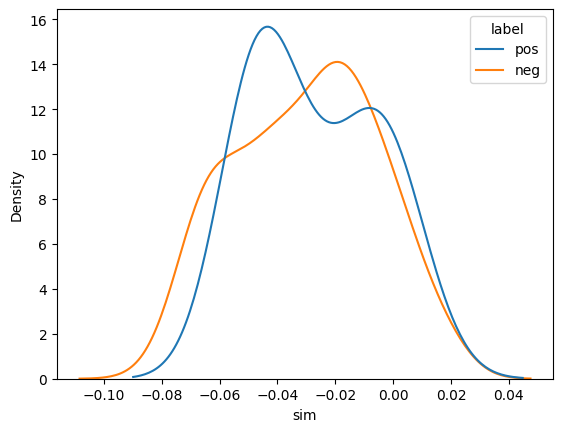

In [56]:
total_sim = np.concatenate([pos_sim, neg_sim])
label = ["pos"] * len(pos_sim) + ["neg"] * len(neg_sim)

print(f"{len(total_sim)} items to plot")

df_dict = {
    "label": label,
    "sim": total_sim,
}

plot_df = pd.DataFrame(df_dict)

dist_plot = sns.kdeplot(
    data=plot_df,
    x="sim",
    hue="label",
    common_norm=False,
)
fig = dist_plot.get_figure()

Aggregating predictions for plot...
Computing similarity...
144 items to plot


/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/s

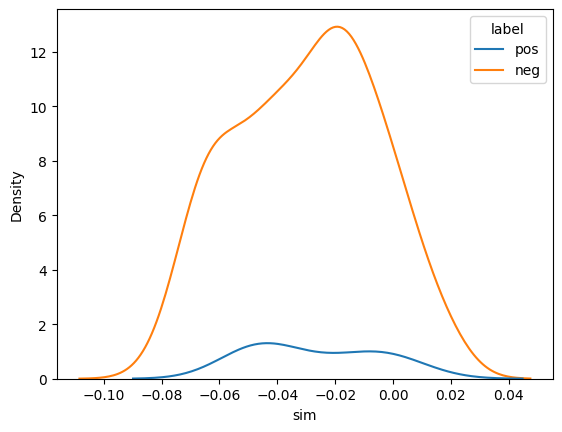

In [101]:
simple.visualize_similarity_dist(predictions, False, False)

## Hint evaluation

In [11]:
cfg.eval.phaseI.datamodule.batch_size = 64
cfg.eval.phaseI.trainer.devices = 1

In [37]:
hint = utils.instantiate_evaluator(cfg.eval.phaseI, cfg.model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [44]:
hint.datamodule.setup()

In [46]:
hint.datamodule.train_dataset.valid_df

,nctid,status,why_stop,label,phase,diseases,icdcodes,drugs,smiless,criteria,valid_smiles
1,NCT01046487,completed,NaN,1,phase 1,['cancer'],"[""['C05.2', 'C10.0', 'C16.0', 'C16.4', 'C17.0'...","['imatinib mesylate, cyclophosphamide (dosing ...",['CC1=NC(NC2=NC=C(S2)C(=O)NC2=C(C)C=CC=C2Cl)=C...,\n Inclusion Criteria:\n\n - ...,[Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(...
2,NCT01381887,completed,NaN,1,phase 1,"['diabetes mellitus, type 2']","[""['E11.65', 'E11.9', 'E11.21', 'E11.36', 'E11...","['placebo', 'canagliflozin 300mg/placebo', 'ca...",['CN1C(=O)C=C(N2CCC[C@@H](N)C2)N(CC2=C(C=CC=C2...,\n Inclusion Criteria:\n\n - ...,[Cn1c(=O)cc(N2CCC[C@@H](N)C2)n(Cc2ccccc2C#N)c1...
3,NCT02015676,completed,NaN,1,phase 1/phase 2,['breast cancer'],"[""['C79.81', 'D24.1', 'D24.2', 'D24.9', 'D49.3...","['trastuzumab', 'paclitaxel', 'myocet']",['[H][N]1([H])[C@@H]2CCCC[C@H]2[N]([H])([H])[P...,\n Inclusion Criteria:\n\n - ...,[CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C...
4,NCT01813955,terminated,\n patient recruitment insufficient\n,0,early phase 1,"['schizophrenia', 'cognitive deficits']","[""['F20.0', 'F20.1', 'F20.2', 'F20.3', 'F20.5'...",['papaverine or placebo'],['COC1=C(OC)C=C(CC2=NC=CC3=CC(OC)=C(OC)C=C23)C...,\n Inclusion Criteria:\n\n - ...,[COc1ccc(Cc2nccc3cc(OC)c(OC)cc23)cc1OC]
5,NCT01213160,completed,NaN,0,phase 1,"['cancer', 'advanced solid malignancies']","[""['C05.2', 'C10.0', 'C16.0', 'C16.4', 'C17.0'...",['azd4547'],['COC1=CC(OC)=CC(CCC2=CC(NC(=O)C3=CC=C(C=C3)N3...,\n Inclusion Criteria:\n\n - Jap...,[COc1cc(CCc2cc(NC(=O)c3ccc(N4C[C@@H](C)N[C@@H]...
...,...,...,...,...,...,...,...,...,...,...,...
1039,NCT01434225,completed,NaN,0,phase 1/phase 2,['neonatal seizures'],"[""['E71.511', 'P29.11', 'P29.12', 'P29.2', 'P3...",['bumetanide'],['CCCCNC1=C(OC2=CC=CC=C2)C(=CC(=C1)C(O)=O)S(N)...,\n Inclusion Criteria:-\n\n - ...,[CCCCNc1cc(C(=O)O)cc(S(N)(=O)=O)c1Oc1ccccc1]
1040,NCT01476137,completed,NaN,0,phase 1,['cancer'],"[""['C05.2', 'C10.0', 'C16.0', 'C16.4', 'C17.0'...","['gsk1120212', 'gsk2110183']",['CN1C(=O)C(C)=C2N(C(=O)N(C3CC3)C(=O)C2=C1NC1=...,\n Inclusion Criteria for Part 1:\n\n ...,[CC(=O)Nc1cccc(-n2c(=O)n(C3CC3)c(=O)c3c(Nc4ccc...
1041,NCT01676233,completed,NaN,1,phase 1,['type 1 diabetes mellitus'],"[""['E10.65', 'E10.9', 'E10.21', 'E10.36', 'E10...","['insulin glargine (hoe901)', 'insulin glargin...","['[Na+].[Na+].[O-]P([O-])(F)=O', '[Na+].[Na+]....",\n Inclusion criteria :\n\n - ...,"[O=P([O-])([O-])F.[Na+].[Na+], O=P([O-])([O-])..."
1042,NCT00331630,completed,NaN,1,early phase 1,['breast cancer'],"[""['C79.81', 'D24.1', 'D24.2', 'D24.9', 'D49.3...","['lapatinib ditosylate', 'paclitaxel albumin-s...",['CS(=O)(=O)CCNCC1=CC=C(O1)C1=CC2=C(C=C1)N=CN=...,\n DISEASE CHARACTERISTICS:\n\n ...,[CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5cc...


In [48]:
hint.run()

No WandbLogger found. WandbCallback will not log anything.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                ┃ Type             ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ molecule_encoder    │ PNA              │  5.0 M │
│ 1  │ head                │ Sequential       │ 66.3 K │
│ 2  │ criterion           │ CrossEntropyLoss │      0 │
│ 3  │ train_loss          │ MeanMetric       │      0 │
│ 4  │ val_loss            │ MeanMetric       │      0 │
│ 5  │ test_loss           │ MeanMetric       │      0 │
│ 6  │ train_other_metrics │ MetricCollection │      0 │
│ 7  │ val_other_metrics   │ MetricCollection │      0 │
│ 8  │ test_other_metrics  │ MetricCollection │      0 │
│ 9  │ train_plot_metrics  │ MetricCollection │      0 │
│ 10 │ val_plot_metrics    │ MetricCollection │      0 │
│ 11 │ test_plot_metrics   │ MetricCollection │      0 │
└────┴─────────────────────┴──────────────────┴────────┘

Trainable params: 5.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 5.0 M                                                                                                
Total estimated model params size (MB): 20

Output()

Metric hint/phase_I/val/loss improved. New best score: 0.698


Metric hint/phase_I/val/loss improved by 0.003 >= min_delta = 0. New best score: 0.695


Metric hint/phase_I/val/loss improved by 0.006 >= min_delta = 0. New best score: 0.689


/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:53: 
UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")

No WandbLogger found. WandbCallback will not log anything.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Empty edges for [Cl-].[Cl-].[Mg+2]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃            Test metric            ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   hint/phase_I/test/BinaryAUROC   │         0.567720890045166         │
│ hint/phase_I/test/BinaryAccuracy  │        0.5764706134796143         │
│  hint/phase_I/test/BinaryF1Score  │        0.6873449087142944         │
│ hint/phase_I/test/BinaryPrecision │        0.5868644118309021         │
│  hint/phase_I/test/BinaryRecall   │        0.8293412923812866         │
│      hint/phase_I/test/loss       │        0.6836665272712708         │
└───────────────────────────────────┴───────────────────────────────────┘

In [73]:
hint.datamodule.setup()

In [76]:
dl = hint.datamodule.train_dataloader()
b = next(iter(dl))

In [79]:
b1 = copy.deepcopy(b)

In [98]:
smiles_list = b1["smiles_list"]
targets = b1["label"]

compound_embeddings = hint.model.forward_smiles_lst_lst(smiles_list)
logits = hint.model.head(compound_embeddings)

loss = hint.model.criterion(logits, targets)

In [100]:
logits, targets

(tensor([[ 0.1056,  0.0534],
         [ 0.0530, -0.0058],
         [ 0.0882, -0.0338],
         [ 0.0678,  0.0005]], grad_fn=<AddmmBackward0>),
 tensor([0, 0, 0, 1]))

In [96]:
logits.shape

torch.Size([4, 2])

## OGB evals

In [6]:
cfg.eval.hiv.datamodule.batch_size = 4
cfg.eval.hiv.trainer.devices = 1

with open_dict(cfg.eval.hiv.trainer):
    cfg.eval.hiv.trainer.limit_train_batches = 3

In [129]:
tox = utils.instantiate_evaluator(cfg.eval.hiv, cfg.model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [130]:
tox.datamodule.setup()

In [131]:
dl = tox.datamodule.train_dataloader()
b = next(iter(dl))

In [139]:
targets, logits

(tensor([1, 1, 0, 0], dtype=torch.int32),
 tensor([[ 0.0538,  0.0796],
         [-0.2209, -0.0526],
         [-0.1225, -0.1160],
         [ 0.0763, -0.0974]], grad_fn=<AddmmBackward0>))

In [144]:
loss

tensor(0.7409, grad_fn=<NllLossBackward0>)

In [118]:
logits.shape, targets

(torch.Size([4, 2]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [7]:
cfg.eval.esol.datamodule.batch_size = 4
cfg.eval.esol.trainer.devices = 1

with open_dict(cfg.eval.esol.trainer):
    cfg.eval.esol.trainer.limit_train_batches = 3

In [15]:
esol = utils.instantiate_evaluator(cfg.eval.esol, cfg.model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
esol.datamodule.setup()

In [17]:
dl = esol.datamodule.train_dataloader()
b = next(iter(dl))

In [18]:
b1 = copy.deepcopy(b)

compound = b1["compound"]
targets = b1["label"]

logits = esol.model.model(compound)

loss = esol.model.criterion(logits, targets)

In [20]:
logits, targets

(tensor([[-0.0000],
         [-0.2658],
         [-0.7437],
         [ 0.1805]], grad_fn=<MulBackward0>),
 tensor([[-1.3900],
         [-3.3900],
         [-1.6400],
         [ 0.5400]]))

In [21]:
esol.model.loss_dict["train"](loss)
esol.model.plot_metrics_dict["train"](logits, targets)
other_metrics = esol.model.other_metrics_dict["train"](logits, targets)

In [22]:
esol.model.loss_dict["train"](loss)

tensor(3.1564, grad_fn=<SqueezeBackward0>)

In [23]:
esol.model.plot_metrics_dict["train"](logits, targets)

{}

In [24]:
other_metrics = esol.model.other_metrics_dict["train"](logits, targets)

In [25]:
other_metrics

{'ogb/esol/train/MeanSquaredError': tensor(3.1564, grad_fn=<SqueezeBackward0>),
 'ogb/esol/train/MeanAbsoluteError': tensor(1.4425, grad_fn=<SqueezeBackward0>),
 'ogb/esol/train/R2Score': tensor(-0.6266, grad_fn=<SqueezeBackward0>)}